### Student Information
Name: 吳文婷

Student ID: d301111002  

GitHu ID: Jillwu0506  

Kaggl name: JillwuTMU

Kaggle private scoreboard snapshot:
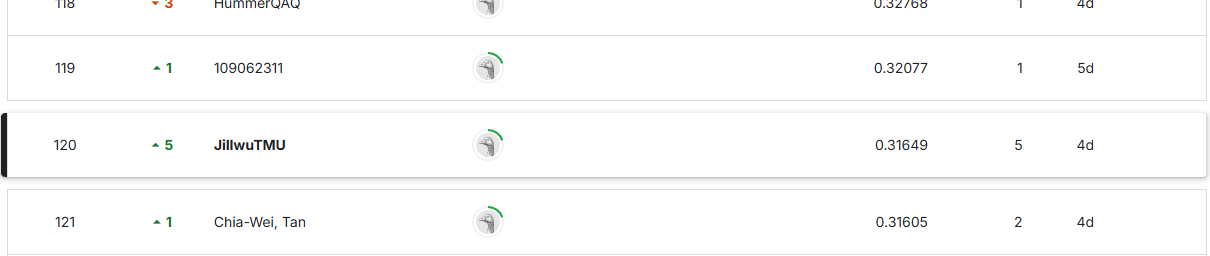


In [1]:
import json
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## **Data Preparation** 

In [2]:
# Read data from kaggle dataset
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
 
f.close()

emotion = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv')
data_identification = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv')

In [3]:
# data transformation
df = pd.DataFrame(data)
_source = df['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'hashtags': _source.apply(lambda x: x['hashtags']),
    'text': _source.apply(lambda x: x['text']),
})
df = df.merge(data_identification, on='tweet_id', how='left')

# split data to train and test
train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

# drop the identification column
train_data = train_data.drop(columns=['identification'])
test_data = test_data.drop(columns=['identification'])

# Merge emotion for corresponding tweet_id
train_data = train_data.merge(emotion, on='tweet_id', how='left') 

In [4]:
# print information
print(train_data.shape)
print(train_data.dtypes)
print(train_data['emotion'].value_counts())
train_data.head()

(1455563, 4)
tweet_id    object
hashtags    object
text        object
emotion     object
dtype: object
emotion
joy             516017
anticipation    248935
trust           205478
sadness         193437
disgust         139101
fear             63999
surprise         48729
anger            39867
Name: count, dtype: int64


,tweet_id,hashtags,text,emotion
0,0x376b20,[Snapchat],"People who post ""add me on #Snapchat"" must be ...",anticipation
1,0x2d5350,"[freepress, TrumpLegacy, CNN]","@brianklaas As we see, Trump is dangerous to #...",sadness
2,0x1cd5b0,[],Now ISSA is stalking Tasha 😂😂😂 <LH>,fear
3,0x1d755c,"[authentic, LaughOutLoud]",@RISKshow @TheKevinAllison Thx for the BEST TI...,joy
4,0x2c91a8,[],Still waiting on those supplies Liscus. <LH>,anticipation


In [5]:
# print information
print(test_data.shape)
print(test_data.dtypes)
test_data.head()

(411972, 3)
tweet_id    object
hashtags    object
text        object
dtype: object


,tweet_id,hashtags,text
2,0x28b412,[bibleverse],"Confident of your obedience, I write to you, k..."
4,0x2de201,[],"""Trust is not the same as faith. A friend is s..."
9,0x218443,"[materialism, money, possessions]",When do you have enough ? When are you satisfi...
30,0x2939d5,"[GodsPlan, GodsWork]","God woke you up, now chase the day #GodsPlan #..."
33,0x26289a,[],"In these tough times, who do YOU turn to as yo..."


## **Preprocessing**

In [6]:
# Dealing with Missing data
def check_missing_values(series):
    """
    Check missing values in a Series
    
    Args:
        series: pandas Series object
        
    Returns:
        dict: dictionary containing missing value statistics
    """
    missing_count = series.isnull().sum()
    total_count = len(series)
    missing_percentage = (missing_count / total_count) * 100
    
    return {
        'Missing Values': missing_count,
        'Total Count': total_count,
        'Missing Percentage(%)': round(missing_percentage, 2)
    }

# Check missing values for each column
missing_train = train_data.apply(check_missing_values)
missing_test = test_data.apply(check_missing_values)

print(missing_train)
print(missing_test)

tweet_id    {'Missing Values': 0, 'Total Count': 1455563, ...
hashtags    {'Missing Values': 0, 'Total Count': 1455563, ...
text        {'Missing Values': 0, 'Total Count': 1455563, ...
emotion     {'Missing Values': 0, 'Total Count': 1455563, ...
dtype: object
tweet_id    {'Missing Values': 0, 'Total Count': 411972, '...
hashtags    {'Missing Values': 0, 'Total Count': 411972, '...
text        {'Missing Values': 0, 'Total Count': 411972, '...
dtype: object


In [7]:
#Dealing with Duplicate Data
sum(train_data.duplicated('text')) 
train_data.drop_duplicates(subset=['text'], keep=False, inplace=True) # Remove duplication = 1449182

In [8]:
pip install emoji


Note: you may need to restart the kernel to use updated packages.


In [9]:
# Clean and standardize text
import re
import emoji
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('stopwords')

def clean_text(text):
    """
    Clean and standardize text
    """
    #switch emoji to text
    text = emoji.demojize(text, delimiters=[":", ":"])
    # Convert to lowercase
    text = str(text).lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^\w\s_]', '', text)
    text = re.sub(r'\d+', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def preprocess_data(df):
    """
    Preprocess both text and hashtags using the same cleaning function
    """
    # Clean text
    df['cleaned_text'] = df['text'].apply(clean_text)
    
    # Clean hashtags - convert list to string and clean
    df['cleaned_hashtags'] = df['hashtags'].apply(lambda x: clean_text(' '.join(x) if isinstance(x, list) else ''))
    
    # Combine text and hashtags
    df['combined_text'] = df.apply(lambda x: 
        x['cleaned_text'] + ' ' + x['cleaned_hashtags'], axis=1)
    
    return df

processed_train = preprocess_data(train_data)
processed_test = preprocess_data(test_data)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
#Sampling Only using 10% of data 
train_data_sample = processed_train.sample(frac=0.1) # Get sample
train_data_sample.shape

(144918, 7)

## **Feature engineering**

**BOW**

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# build analyzers (bag-of-words)
BOW_500 = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 

# apply analyzer to training data
BOW_500.fit(train_data_sample['combined_text'])
train_data_BOW_features_500 = BOW_500.transform(train_data_sample['combined_text'])

## check dimension
train_data_BOW_features_500.shape

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(144918, 500)

### **Prepare train data and one hot encoding**

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# for a classificaiton problem, you need to provide both training & testing data
X_train_data = train_data_BOW_features_500
y_train_data = train_data_sample['emotion']

le = LabelEncoder() # Label target
y_train_le = le.fit_transform(y_train_data)

# Split training and testing data for evaluation.
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_le, test_size=0.3, random_state=42, stratify=y_train_le) 

#check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)


X_train.shape:  (101442, 500)
y_train.shape:  (101442,)
X_test.shape:  (43476, 500)
y_test.shape:  (43476,)


### **Naive Bayes**

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# 訓練 Naive Bayes 模型
model = MultinomialNB()
model.fit(X_train, y_train)

# 預測測試集
y_pred = model.predict(X_test)

## **Results evaluation**

In [14]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred) # Evaluation

0.40928328273070197

## **testing data**

In [15]:
# apply analyzer to training data
test_data_BOW_features_500 = BOW_500.transform(processed_test['combined_text'])
# for a classificaiton problem, you need to provide both training & testing data
X_test_data = test_data_BOW_features_500
# 預測測試集
y_pred = model.predict(X_test_data)

In [16]:
# Inverse predict labels back to adjective words
y_pred_labels = le.inverse_transform(y_pred) 

## **Submission**

In [17]:
submission = pd.DataFrame({
    'id': processed_test['tweet_id'],
    'emotion': y_pred_labels
})

In [18]:
submission.to_csv('/kaggle/working/submission.csv', index=False)

In [19]:
submission

,id,emotion
2,0x28b412,anticipation
4,0x2de201,anticipation
9,0x218443,sadness
30,0x2939d5,anticipation
33,0x26289a,anticipation
...,...,...
1867525,0x2913b4,joy
1867529,0x2a980e,disgust
1867530,0x316b80,joy
1867531,0x29d0cb,joy
